In [2]:
#From https://towardsdatascience.com/tile-slice-yolo-dataset-for-small-objects-detection-a75bf26f7fa2
#Needs troubleshooting

import pandas as pd
import numpy as np
from PIL import Image
from shapely.geometry import Polygon, Point
from matplotlib import pyplot as plt
import glob

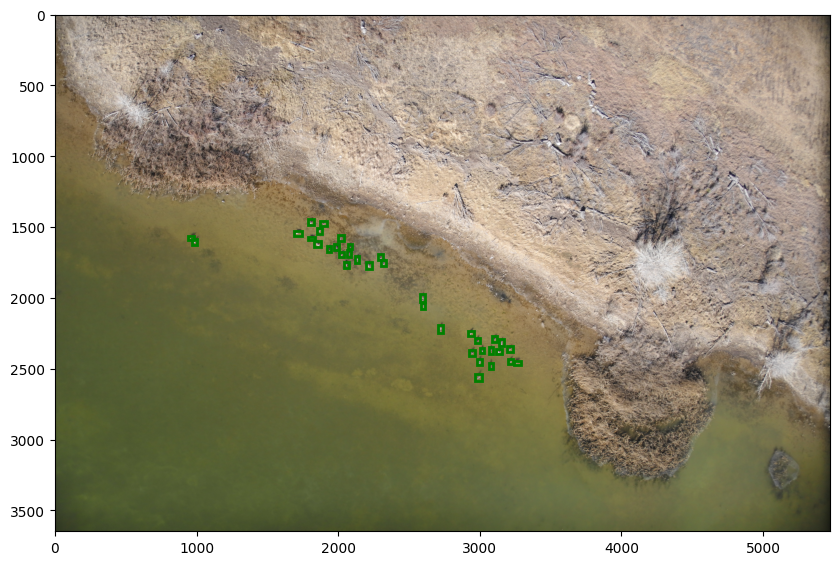

In [5]:
imname = 'mxw_L13_20181215_1'
im = Image.open(f'C:\\Users\\rowanconverse\\Desktop\\usfws\\images\\test\\{imname}.JPG')
df = pd.read_csv(f'C:\\Users\\rowanconverse\\Desktop\\usfws\\labels\\test\\{imname}.txt', sep=' ', names=['class', 'x1', 'y1', 'w', 'h'])
imr = np.array(im, dtype=np.uint8)

df_scaled = df.iloc[:, 1:]
df_scaled[['x1', 'w']] = df_scaled[['x1', 'w']] * imr.shape[1]
df_scaled[['y1', 'h']] = df_scaled[['y1', 'h']] * imr.shape[0]

import matplotlib.patches as patches# Create figure and axes
fig,ax = plt.subplots(1, figsize=(10,10))# Display the image
ax.imshow(imr)
for box in df_scaled.values:
    # Create a Rectangle patch
    rect = patches.Rectangle((box[0]-(box[2]/2),box[1]-(box[3]/2)),box[2],box[3],linewidth=2,edgecolor='g',facecolor='none')# Add the patch to the axes
    ax.add_patch(rect)
    
plt.show()

In [6]:
# get all image names
imnames = glob.glob('C:\\Users\\rowanconverse\\Desktop\\usfws\\images\\test\\*.JPG')

# specify path for a new tiled dataset
newpath = 'C:\\Users\\rowanconverse\\Desktop\\usfws\\images\\test\\tiles'
falsepath = 'C:\\Users\\rowanconverse\\Desktop\\usfws\\images\\test\\false'

# specify slice width=height
slice_size = 521

# tile all images in a loop

for imname in imnames:
    im = Image.open(imname)
    imr = np.array(im, dtype=np.uint8)
    height = imr.shape[0]
    width = imr.shape[1]
    labname = imname.replace('.JPG', '.txt')
    labels = pd.read_csv(labname, sep=' ', names=['class', 'x1', 'y1', 'w', 'h'], encoding="latin")
    
    # we need to rescale coordinates from 0-1 to real image height and width
    labels[['x1', 'w']] = labels[['x1', 'w']] * width
    labels[['y1', 'h']] = labels[['y1', 'h']] * height
    
    boxes = []
    
    # convert bounding boxes to shapely polygons. We need to invert Y and find polygon vertices from center points
    for row in labels.iterrows():
        x1 = row[1]['x1'] - row[1]['w']/2
        y1 = (height - row[1]['y1']) - row[1]['h']/2
        x2 = row[1]['x1'] + row[1]['w']/2
        y2 = (height - row[1]['y1']) + row[1]['h']/2

        boxes.append((int(row[1]['class']), Polygon([(x1, y1), (x2, y1), (x2, y2), (x1, y2)])))
    
    counter = 0
    print('Image:', imname)
    # create tiles and find intersection with bounding boxes for each tile
    for i in range((height // slice_size)):
        for j in range((width // slice_size)):
            x1 = j*slice_size
            y1 = height - (i*slice_size)
            x2 = ((j+1)*slice_size) - 1
            y2 = (height - (i+1)*slice_size) + 1

            pol = Polygon([(x1, y1), (x2, y1), (x2, y2), (x1, y2)])
            imsaved = False
            slice_labels = []

            for box in boxes:
                if pol.intersects(box[1]):
                    inter = pol.intersection(box[1])        
                    
                    if not imsaved:
                        sliced = imr[i*slice_size:(i+1)*slice_size, j*slice_size:(j+1)*slice_size]
                        sliced_im = Image.fromarray(sliced)
                        filename = imname.split('/')[-1]
                        slice_path = newpath + filename.replace('.JPG', f'_{i}_{j}.JPG')
                        
                        slice_labels_path = newpath + filename.replace('.JPG', f'_{i}_{j}.txt')
                        
                        print(slice_path)
                        sliced_im.save(slice_path)
                        imsaved = True                    
                    
                    # get the smallest polygon (with sides parallel to the coordinate axes) that contains the intersection
                    new_box = inter.envelope 
                    
                    # get central point for the new bounding box 
                    centre = new_box.centroid
                    
                    # get coordinates of polygon vertices
                    x, y = new_box.exterior.coords.xy
                    
                    # get bounding box width and height normalized to slice size
                    new_width = (max(x) - min(x)) / slice_size
                    new_height = (max(y) - min(y)) / slice_size
                    
                    # we have to normalize central x and invert y for yolo format
                    new_x = (centre.coords.xy[0][0] - x1) / slice_size
                    new_y = (y1 - centre.coords.xy[1][0]) / slice_size
                    
                    counter += 1

                    slice_labels.append([box[0], new_x, new_y, new_width, new_height])
            
            # save txt with labels for the current tile
            if len(slice_labels) > 0:
                slice_df = pd.DataFrame(slice_labels, columns=['class', 'x1', 'y1', 'w', 'h'])
                print(slice_df)
                slice_df.to_csv(slice_labels_path, sep=' ', index=False, header=False, float_format='%.6f')
            
            # if there are no bounding boxes intersect current tile, save this tile to a separate folder 
            if not imsaved:
                sliced = imr[i*slice_size:(i+1)*slice_size, j*slice_size:(j+1)*slice_size]
                sliced_im = Image.fromarray(sliced)
                filename = imname.split('/')[2]
                slice_path = falsepath + filename.replace('.JPG', f'_{i}_{j}.JPG')                

                sliced_im.save(slice_path)
                print('Slice without boxes saved')
                imsaved = True

ParserError: Error tokenizing data. C error: Expected 5 fields in line 8, saw 9
